In [29]:
from utils import *

In [30]:
# Specify the directory containing the data files
directory_path = './Data/3m-all-angles-and-slopes'
# List all files in the directory
files = [file for file in os.listdir(directory_path) if file != '.DS_Store']
print(files)

['9000-10000-250-100-m50-3-4.csv', '9000-10000-250-100-m40-3-4.csv', '9000-10000-150-100-m20-3-4.csv', '9000-10000-150-100-m30-3-4.csv', '9000-10000-250-100-30-3-2.csv', '9000-10000-250-100-20-3-2.csv', '9000-10000-250-100-20-3-3.csv', '9000-10000-250-100-30-3-3.csv', '9000-10000-150-100-m30-3-5.csv', '9000-10000-150-100-m20-3-5.csv', '9000-10000-250-100-m40-3-5.csv', '9000-10000-250-100-m50-3-5.csv', '9000-10000-250-100-0-3-1.csv', '9000-10000-250-100-0-3-3.csv', '9000-10000-250-100-20-3-1.csv', '9000-10000-250-100-30-3-1.csv', '9000-10000-200-100-m30-3-4.csv', '9000-10000-200-100-m20-3-4.csv', '9000-10000-200-100-m20-3-5.csv', '9000-10000-200-100-m30-3-5.csv', '9000-10000-250-100-0-3-2.csv', '9000-10000-250-100-m40-3-2.csv', '9000-10000-250-100-m50-3-2.csv', '9000-10000-150-100-m30-3-2.csv', '9000-10000-150-100-m20-3-2.csv', '9000-10000-250-100-20-3-4.csv', '9000-10000-250-100-30-3-4.csv', '9000-10000-200-100-m30-3-1.csv', '9000-10000-200-100-m20-3-1.csv', '9000-10000-250-100-30-3-5.

In [31]:
def parse_bin_name(filename):
    split = filename.split("/")[-1].split(".")
    params = split[0].split("-")
    start_freq = int(params[0])  # MHz
    stop_freq = int(params[1])  # MHz
    cd_time = int(params[2])  # us
    dwells = int(params[3])  # us
    if params[4].startswith("m"):
        angle = -int(params[4][1:])
    else:
        angle = int(params[4])  # degree
    distance = int(params[5])  # m
    trail = int(params[6])
    return start_freq, stop_freq, cd_time, dwells, angle, distance, trail

In [32]:
data_dict = {}
for file in files:
    start_freq, stop_freq, cd_time, dwells, angle, distance, trail = parse_bin_name(file)
    cd = cd_time * 1e-6  # us to s
    dwell = dwells * 1e-6  # us to s
    if file not in data_dict:
        data_dict[file] = {}
    data_dict[file]['data'] = parse_csv_file(os.path.join(directory_path, file))
    data_dict[file]['angle'] = int(angle)
    data_dict[file]['cd'] = cd
    data_dict[file]['slope'] = (stop_freq - start_freq) * 1e6 / cd

In [33]:
# Pre defined parameters
start_freq = 9e9
end_freq = 10e9

bw = (end_freq - start_freq)
gt_slope = bw / cd
delta_L1 = (72 - 3) * 0.0254
delta_L2 = (72 - 48) * 0.0254
delta_L3 = (48 - 3) * 0.0254

d = 0.1

speed_ratio = 0.7453

delta_L1_inch = 72 - 3
delta_L2_inch = 72 - 48
delta_L3_inch = 48 - 3

In [34]:
def estimate_slope_and_angle(frequency_spectrum, expected_ratios, tolerance, predicted_slopes, gt_slopes, gt_values, angle_w_slope, predicted_values ,data_dict, key, frequency_axis, plot_data_dic, plot=False):
    max_peak_value = np.max(frequency_spectrum)
        # Peak detection to find all peaks in the spectrum
    peaks, properties = scipy.signal.find_peaks(frequency_spectrum, height=max_peak_value/7)  # Adjust height threshold based on noise level
    plt.show()
    # peaks, properties = find_peaks(frequency_spectrum, height=0)  # Adjust height threshold based on noise level

    # Store valid peak triplets based on ratio matching, order, and amplitude constraint
    valid_peak_triplets = []

    # Get amplitudes of detected peaks
    peak_amplitudes = properties['peak_heights']

    # Find the largest peak amplitude in the entire spectrum
    largest_amplitude_index = np.argmax(peak_amplitudes)
    largest_peak = peaks[largest_amplitude_index]

    # Variable to store the best triplet based on amplitude sum
    best_triplet = None

    # Define the minimum distance in frequency units between peaks
    min_peak_distance = 1000
    max_amplitude_sum = 0
    # Check all combinations of three peaks for the expected ratios
    for i in range(len(peaks)):
        for j in range(i + 1, len(peaks)):
            for k in range(j + 1, len(peaks)):
                # Enforce the order: peak[k] (L1) > peak[j] (L3) > peak[i] (L2)
                if peaks[k] > peaks[j] > peaks[i]:
                    # Check if the peaks are too close in frequency
                    if (peaks[j] - peaks[i] < min_peak_distance) or (peaks[k] - peaks[j] < min_peak_distance) or (peaks[k] - peaks[i] < min_peak_distance):
                        continue  # Skip this triplet if any peaks are too close

                    # Calculate ratios between the three peaks
                    ratio_1 = peaks[k] / peaks[j]  # L1 to L3
                    ratio_2 = peaks[j] / (peaks[i] + 400)  # L3 to L2
                    ratio_3 = peaks[k] / (peaks[i] + 400)  # L1 to L2

                    # Check if all ratios match the expected ratios within the tolerance
                    if (
                        abs(ratio_1 - expected_ratios[0]) < tolerance and
                        abs(ratio_2 - expected_ratios[1]) < tolerance and
                        abs(ratio_3 - expected_ratios[2]) < tolerance
                    ):
                        # Ensure at least one of the peaks has the largest amplitude
                        if largest_peak in (peaks[i], peaks[j], peaks[k]):
                            # Calculate the sum of the amplitudes of the current triplet
                            amplitude_i = peak_amplitudes[np.where(peaks == peaks[i])[0][0]]
                            amplitude_j = peak_amplitudes[np.where(peaks == peaks[j])[0][0]]
                            amplitude_k = peak_amplitudes[np.where(peaks == peaks[k])[0][0]]

                            if amplitude_k < amplitude_j or amplitude_k < amplitude_i:
                                continue

                            amplitude_sum = amplitude_i + amplitude_j + amplitude_k

                            # Check if this is the largest amplitude sum found so far
                            if amplitude_sum > max_amplitude_sum:
                                max_amplitude_sum = amplitude_sum
                                best_triplet = (peaks[i], peaks[j], peaks[k])
    if best_triplet:
        valid_peaks = list(best_triplet)
        print("Ratio Error", abs(ratio_1 - expected_ratios[0]), abs(ratio_2 - expected_ratios[1]))
    else:
        valid_peaks = []  # No valid triplet found


    # Create a filtered spectrum that only contains the valid three peaks
    filtered_spectrum = np.zeros_like(frequency_spectrum)
    # if len(valid_peaks) == 0:
    #     continue

    # Output filtered spectrum or further process
    print("Filtered peaks at indices:", valid_peaks)
    if len(valid_peaks) != 3:
        print("No valid peaks found")
    else:
        valid_peaks = sorted(valid_peaks)
        sub_peak1 = valid_peaks[-1]
        sub_peak2 = valid_peaks[-3]
        sub_peak3 = valid_peaks[-2]
        print(sub_peak1, sub_peak2, sub_peak3)
        
        # Assuming data_dict is defined somewhere else in the actual use case
        data_dict[key]["sub_peak1"] = frequency_axis[sub_peak1]
        data_dict[key]["sub_peak2"] = frequency_axis[sub_peak2]
        data_dict[key]["sub_peak3"] = frequency_axis[sub_peak3]
    
    print("Filtered spectrum:", filtered_spectrum)
        
    # Plot the original and filtered spectra with actual frequencies on the x-axis
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(frequency_axis, frequency_spectrum, label='Original Spectrum')
        plt.plot(frequency_axis, filtered_spectrum, label='Filtered Spectrum', linestyle='--')
        plt.scatter(frequency_axis[valid_peaks], frequency_spectrum[valid_peaks], color='red', label='Valid Peaks')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.title('Original and Filtered Spectrum with Valid Peaks')
        plt.legend()
        plt.show()
        
    ## Estimate angles
    if "sub_peak1" not in data_dict[key]:
        return
    sub_peak1 = data_dict[key]["sub_peak1"]
    sub_peak2 = data_dict[key]["sub_peak2"]
    sub_peak3 = data_dict[key]["sub_peak3"]
    
    
    sub_peak2 = sub_peak2 + 1300
    print("Sub peak2", sub_peak2, plot_data_dic["peak2"])
    # gap_for_slope = sub_peak2 - 2 * sub_peak1
    # predicted_slope = (gap_for_slope * speed_ratio * c) / (delta_L2 - 2 * delta_L1)

    
    gt_slope = 1e9 / data_dict[key]['cd']

    
    predicted_slope = (sub_peak1 + sub_peak3) / ((delta_L1 + delta_L3) / (speed_ratio * c))
        
    predicted_slopes.append(predicted_slope)
    gt_slopes.append(gt_slope)
    
    theta1 = np.rad2deg(np.arcsin(((sub_peak1 * c) / predicted_slope - (delta_L1 / speed_ratio)) / d))
    
    theta3 = np.rad2deg(np.arcsin(((sub_peak3 * c) / predicted_slope + (delta_L3 / speed_ratio)) / d))
    
    theta2 = np.rad2deg(np.arcsin(((sub_peak2 * c) / predicted_slope - (delta_L2 / speed_ratio)) / (2*d)))
    print(f"Predicted slope: {predicted_slope} {gt_slope} {angle} {theta1} {theta2} {theta3}")
    gt_values.append(angle)
    predicted_values.append(theta2)
    
    if gt_slope not in angle_w_slope:
        angle_w_slope[gt_slope] = {}
    if angle not in angle_w_slope[gt_slope]:
        angle_w_slope[gt_slope][angle] = []
    angle_w_slope[gt_slope][angle].append(theta2)

In [35]:
plot = False
predicted_slopes = []
gt_slopes = []
gt_values = []
predicted_values = []
cali_peaks = []

gt_angles = []
predicted_peak2s = []
theory_peak_2s = []

data_slope = []

angle_w_slope = {}

zero_sub_peak2 = []

slope_mismatch_angles = []

# Convert frequency indices to actual frequencies
l_freq = 0
r_freq = 8e4
nfft = 2**14
frequency_axis = np.linspace(l_freq, r_freq, nfft)

for key in data_dict:
    print("filename: ", key)
    angle = data_dict[key]['angle']
    theta = np.deg2rad(float(angle))
    # Theroetical peak frequencies shift
    theta_shift = (d * np.sin(theta) / c) * data_dict[key]['slope']
    
    data = data_dict[key]['data']
    timestamp = data[:, 0]
    amplitude = data[:, 1] * 1.0
    fs = len(timestamp) / ((timestamp[-1] - timestamp[0])) # timestamps in 1us
    print(f"Sampling freq: {fs}")
    # Plot the data
    cd = data_dict[key]['cd']
    print(f"CD: {cd}")
    # if cd != 150 * 1e-6:
    #     print("Slope too low, skipping")
    #     continue
    # if angle != 0:
    #     continue
    expected_period = cd + 100e-6
    theory_peak_1 = get_output_theory(delta_L1_inch, bw, cd, speed_ratio=speed_ratio)
    theory_peak_2 = get_output_theory(delta_L2_inch, bw, cd, speed_ratio=speed_ratio)
    theory_peak_3 = get_output_theory(delta_L3_inch, bw, cd, speed_ratio=speed_ratio)
    # data_dict[key]["theory_peak_2"] = theory_peak_2
    
    Xs, segment_indices = crop_signal_tolist(amplitude, fs, None, num_segments = 5, crop_factor = 8, plot = False, window_length = 15)
    # print(f"Segment indices: {segment_indices}")
    plot_data_dic = {}
    plot_data_dic["filename"] = str(angle) + "_" + key
    plot_data_dic["peak1"] = theory_peak_1 + theta_shift
    plot_data_dic["peak2"] = theory_peak_2 + 2 * theta_shift
    plot_data_dic["peak3"] = theory_peak_3 - theta_shift

    expected_ratios = [
        delta_L1 / delta_L3,  # Ratio 1 (L1 to L3)
        delta_L3 / delta_L2,   # Ratio 2 (L3 to L2)
        delta_L1 / delta_L2,   # Ratio 2 (L3 to L2)
    ]
    tolerance = 0.6  # Tolerance for ratio matching
    
    
    for index, X in enumerate(Xs):
        # Detect frequency peaks in the signal
        # peaks, spectrum = detect_frequency(X, fs, plot_data_dic, signal_count = 3, plot = plot)
        peaks, spectrum = peaks_old, spectrum_old = detect_frequency_classic_music(X, fs, plot_data_dic, signal_count=3, dim_signal_space = 3, plot=False, l_freq=l_freq, r_freq=r_freq)
        # w, spectrum = zoom_fft(X[:, 3]* signal.windows.kaiser(X.shape[0], beta = 5), fs, l_freq, r_freq, nfft)

        # peaks, spectrum = detect_frequency_spatial_smoothing(X, fs, signal_count = 3, spatial_window = 20, plot = True)
        # sub_peaks
        frequency_spectrum = spectrum 
        estimate_slope_and_angle(frequency_spectrum, expected_ratios, tolerance, predicted_slopes, gt_slopes, gt_values, angle_w_slope, predicted_values ,data_dict, key, frequency_axis, plot_data_dic, plot=False)

filename:  9000-10000-250-100-m50-3-4.csv
Sampling freq: 200100.4520341537
CD: 0.00025
(54, 5)
(54, 5)
(54, 5)
(54, 5)
(54, 5)
Ratio Error 0.4590917524816771 0.7357213634562032
Filtered peaks at indices: [2000, 5126, 6281]
6281 2000 5126
Filtered spectrum: [0. 0. 0. ... 0. 0. 0.]
Sub peak2 11066.221082829763 8869.02603657415
Predicted slope: 4298146889791.548 4000000000000.0 -50 nan -13.31626881295413 nan
Ratio Error 0.4169757128742444 0.7691992529918441
Filtered peaks at indices: [2062, 4367, 6293]
6293 2062 4367
Filtered spectrum: [0. 0. 0. ... 0. 0. 0.]
Sub peak2 11368.973936397486 8869.02603657415
Predicted slope: 4016677991161.3833 4000000000000.0 -50 -35.441789103107666 8.806469973790332 nan
Ratio Error 0.41626888598482226 0.7654914529914532
Filtered peaks at indices: [1933, 4476, 6304]
6304 1933 4476
Filtered spectrum: [0. 0. 0. ... 0. 0. 0.]
Sub peak2 10739.052676554966 8869.02603657415
Predicted slope: 4061893878491.531 4000000000000.0 -50 -52.70654790125709 -7.272673307747576

/var/folders/b8/hkb_33g56ysdqtzxhgm3bg640000gn/T/ipykernel_26520/356727832.py:125: RuntimeWarning: invalid value encountered in arcsin
  theta1 = np.rad2deg(np.arcsin(((sub_peak1 * c) / predicted_slope - (delta_L1 / speed_ratio)) / d))
/var/folders/b8/hkb_33g56ysdqtzxhgm3bg640000gn/T/ipykernel_26520/356727832.py:127: RuntimeWarning: invalid value encountered in arcsin
  theta3 = np.rad2deg(np.arcsin(((sub_peak3 * c) / predicted_slope + (delta_L3 / speed_ratio)) / d))


Ratio Error 0.44652973175764377 0.8229760230888776
Filtered peaks at indices: [1532, 4655, 6168]
6168 1532 4655
Filtered spectrum: [0. 0. 0. ... 0. 0. 0.]
Sub peak2 8780.925349447598 9197.938469541197
Predicted slope: 4078096238118.167 4000000000000.0 -40 nan -59.550289325146665 nan
Ratio Error 0.41513099391203223 0.6869463632669648
Filtered peaks at indices: [1728, 4612, 6571]
6571 1728 4612
Filtered spectrum: [0. 0. 0. ... 0. 0. 0.]
Sub peak2 9738.015015564915 9197.938469541197
Predicted slope: 4213743900108.607 4000000000000.0 -40 -43.368980998871024 -38.7194595643315 nan
Ratio Error 0.3474756421612044 0.7772848808945068
Filtered peaks at indices: [1686, 4571, 6526]
6526 1686 4571
Filtered spectrum: [0. 0. 0. ... 0. 0. 0.]
Sub peak2 9532.92437282549 9197.938469541197
Predicted slope: 4181339180855.336 4000000000000.0 -40 -41.86086487762988 -42.235847112506626 nan
Ratio Error 0.3972218271464465 0.7427027135840247
Filtered peaks at indices: [1662, 4600, 6522]
6522 1662 4600
Filtered s

/var/folders/b8/hkb_33g56ysdqtzxhgm3bg640000gn/T/ipykernel_26520/356727832.py:129: RuntimeWarning: invalid value encountered in arcsin
  theta2 = np.rad2deg(np.arcsin(((sub_peak2 * c) / predicted_slope - (delta_L2 / speed_ratio)) / (2*d)))


(55, 5)
(55, 5)
(55, 5)
(55, 5)
(55, 5)
Ratio Error 0.436029062266585 0.7967308537121103
Filtered peaks at indices: [2134, 4460, 6500]
6500 2134 4460
Filtered spectrum: [0. 0. 0. ... 0. 0. 0.]
Sub peak2 11720.557895379356 10000.540291794832
Predicted slope: 4129717709486.751 4000000000000.0 -20 -28.287064555423665 9.47276342741067 nan
Ratio Error 0.2992146800404323 0.7372611464968155
Filtered peaks at indices: [1985, 4434, 6493]
6493 1985 4434
Filtered spectrum: [0. 0. 0. ... 0. 0. 0.]
Sub peak2 10992.97442470854 10000.540291794832
Predicted slope: 4117283340470.961 4000000000000.0 -20 -25.416295170530724 -5.017595932712075 nan
Ratio Error 0.46404848812581667 0.7754830917874398
Filtered peaks at indices: [2150, 4484, 6477]
6477 2150 4484
Filtered spectrum: [0. 0. 0. ... 0. 0. 0.]
Sub peak2 11798.687664041994 10000.540291794832
Predicted slope: 4130094508547.8354 4000000000000.0 -20 -33.88414996894407 11.101447996068334 nan
Ratio Error 0.4636079482027238 0.7579031051253275
Filtered peak

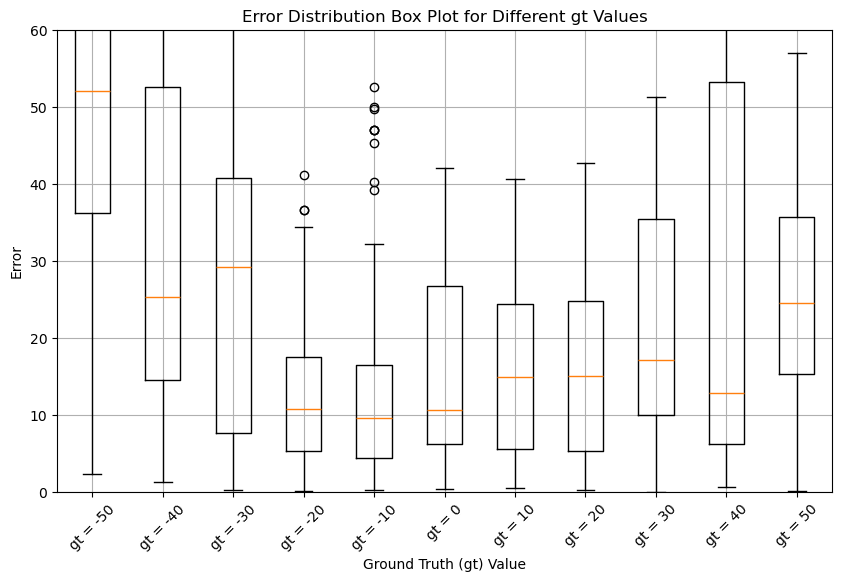

In [36]:
# Assuming predicted_values and gt_values are defined
predicted_values_array = np.array(predicted_values)
predicted_values_array_offset = np.array(predicted_values_array)
gt_values = np.array(gt_values)
gt_values_unique = list(range(-50, 51, 10))

# Calculate errors for each unique gt value
errors_dict = {gt: np.abs(predicted_values_array_offset[gt_values == gt] - gt) for gt in gt_values_unique}

# Prepare data for the box plot
errors_data = [errors_dict[gt][~np.isnan(errors_dict[gt])] for gt in gt_values_unique]

# Plot box plot
plt.figure(figsize=(10, 6))

plt.boxplot(errors_data, labels=[f'gt = {gt}' for gt in gt_values_unique], showfliers=True)
plt.title('Error Distribution Box Plot for Different gt Values')
plt.xlabel('Ground Truth (gt) Value')
plt.ylabel('Error')
plt.ylim(0, 60)
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

     Ground Truth     Predicted
0    4.000000e+12  4.298147e+12
1    4.000000e+12  4.016678e+12
2    4.000000e+12  4.061894e+12
3    4.000000e+12  4.022330e+12
4    4.000000e+12  4.052851e+12
..            ...           ...
892  6.666667e+12  7.029563e+12
893  6.666667e+12  7.077417e+12
894  6.666667e+12  7.048403e+12
895  6.666667e+12  7.038606e+12
896  6.666667e+12  7.047273e+12

[897 rows x 2 columns]


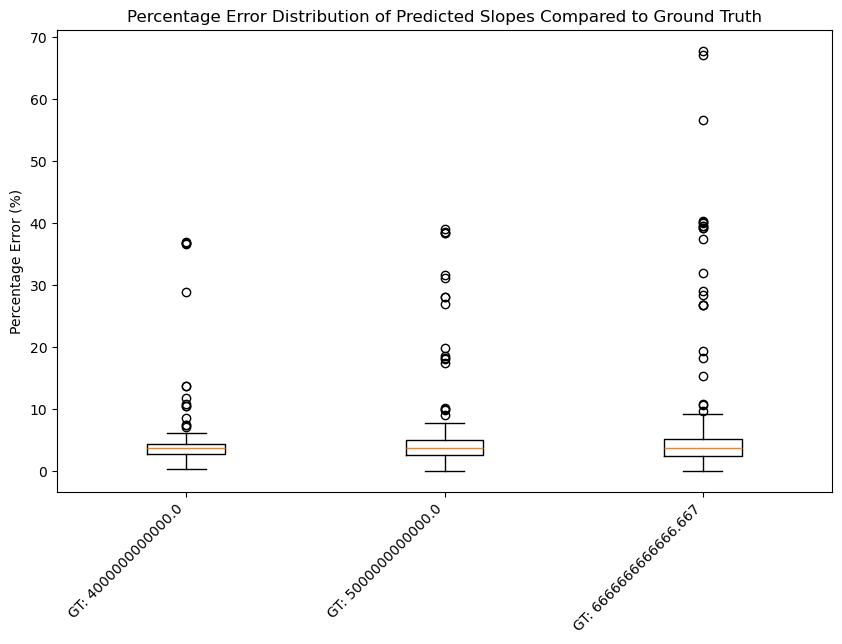

In [37]:
# Create a DataFrame for easier manipulation
data = pd.DataFrame({'Ground Truth': gt_slopes, 'Predicted': predicted_slopes})
print(data)
# Calculate the absolute error
data['Error'] = np.abs(data['Predicted'] - data['Ground Truth'])
# Calculate the percentage error
data['Percentage Error'] = (data['Error'] / data['Ground Truth']) * 100

# Group by unique ground truth slope values to calculate percentage error distribution
grouped_percentage_error = data.groupby('Ground Truth')['Percentage Error'].apply(list)

# Specify the filename
filename = 'Data/processed_data/ab_low_slope_error_classic_music.csv'

grouped_percentage_error.to_csv(filename, header=True)


# Prepare data for the box plot of percentage errors
boxplot_percentage_error_data = [grouped_percentage_error[key] for key in grouped_percentage_error.keys()]
percentage_error_labels = [f'GT: {key}' for key in grouped_percentage_error.keys()]

# Create the box plot for percentage errors
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(boxplot_percentage_error_data, labels=percentage_error_labels)

# Add title and labels
ax.set_title('Percentage Error Distribution of Predicted Slopes Compared to Ground Truth')
ax.set_ylabel('Percentage Error (%)')

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [38]:
per_slope_angle_error = {}
for slope in angle_w_slope:
    print(slope)
    if slope not in per_slope_angle_error:
        per_slope_angle_error[slope] = {}
    for angle in angle_w_slope[slope]:
        errors = []
        for predicted_angle in angle_w_slope[slope][angle]:
            error = abs(angle - predicted_angle)
            errors.append(error)
        if angle not in per_slope_angle_error[slope]:
            per_slope_angle_error[slope][angle] = errors
            

4000000000000.0
6666666666666.667
5000000000000.0


In [39]:
import json
# Specify the filename
filename = 'Data/processed_data/ab_low_mp_angle_error_classic_music.json'

# Save the dictionary to a JSON file
with open(filename, 'w') as file:
    json.dump(per_slope_angle_error, file, indent=4)  # The indent parameter makes the JSON file more readable